#  Data Analysis and Visualization

Import in libraries and create functions to query the database

In [4]:
import pandas as pd 
import mariadb
import mysql.connector
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests


#############################
##  LOCAL DATABASE SERVER  ##
#############################
def query_db(query, printable=True):
    try:
        df = pd.DataFrame()

        conn = mysql.connector.connect(
            user="root",
            password="password",
            host="localhost",
            port=3306,
            database="creditcard_capstone"
        )

        cur = conn.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        df = pd.read_sql_query(query, conn)

        if printable:
            print(tabulate(df, headers='keys', tablefmt='fancy_grid'))
            print("\n===========================================\n\n")

    except mariadb.Error as e:
        print(f"ERROR connecting to MariaDB:  {e}")

    finally:
        conn.close()
        if not df.empty:
            return df
        else:
            print("DATAFRAME IS EMPTY!  Something went wrong!")



In [ ]:
#######################################################
##  ONLINE SERVER  MAKE SURE THE HOST IS AVAILABLE  ##
#######################################################
'''
def query_db(query, printable=True):
    try:
        df = pd.DataFrame()
        with open('../.secrets', 'r') as f:
            CREDITCARD_CAPSTONE_PASSWORD = f.read()

        conn = mariadb.connect(
            user="michaelwschmidt_cc_capstone",
            password=CREDITCARD_CAPSTONE_PASSWORD,
            host="tommy2.heliohost.org",
            port=3306,
            database="michaelwschmidt_creditcard_capstone"
        )

        cur = conn.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        df = pd.read_sql_query(query, conn)

        if printable:
            print(tabulate(df, headers='keys', tablefmt='fancy_grid'))
            print("\n===========================================\n\n")

    except mariadb.Error as e:
        print(f"ERROR connecting to MariaDB:  {e}")

    finally:
        conn.close()
        if not df.empty:
            return df
        else:
            print("DATAFRAME IS EMPTY!  Something went wrong!")
'''

#### Find and plot which transaction type has a high rate of transactions. (Functional Requirements 3.1)

In [5]:
query = "SELECT transaction_type, count(*) as count from cdw_sapp_credit_card GROUP BY 1"
df_cc = query_db(query, False)
df_cc.set_index(df_cc.columns[0], inplace=True)
#df_cc.index = df_cc["transaction_type"]
df_cc

C:\Users\mikey\AppData\Local\Temp\ipykernel_19584\2148237052.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,count
transaction_type,
Education,6638
Entertainment,6635
Grocery,6549
Gas,6605
Bills,6861
Test,6683
Healthcare,6723


''

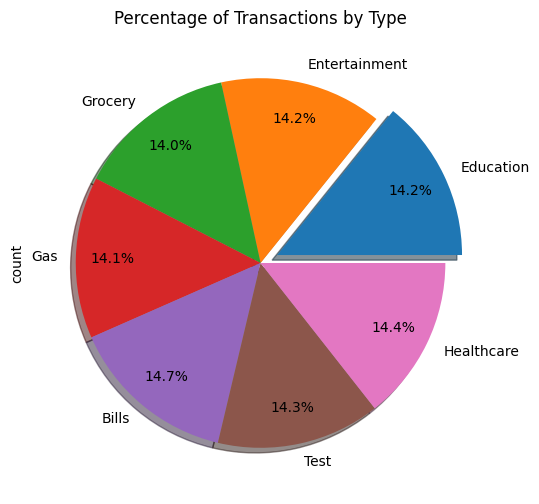

In [6]:
#plt.pie(df_cc["count"], labels=df_cc.index, autopct='%.0f%%')

df_cc["count"].plot(kind='pie',
                    figsize=(15,6),
                    autopct='%1.1f%%',
                    shadow=True,
                    pctdistance=.80,
                    explode=[0.1, 0,0,0,0,0,0]
                    )

plt.title("Percentage of Transactions by Type")


;

''

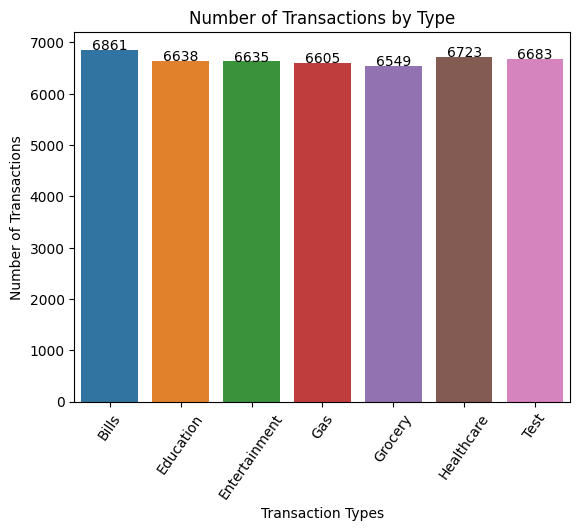

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')

#df_cc_trans = query_db("SELECT * FROM cdw_sapp_credit_card", False)
sns.barplot(x=df_cc.index, y="count", data=df_cc)
plt.xticks(rotation=55)
addlabels(df_cc.index, df_cc["count"])
plt.title("Number of Transactions by Type")
plt.xlabel("Transaction Types")
plt.ylabel("Number of Transactions")
;

#### Find and plot which state has a high number of customers. (Functional Requirements 3.2)

In [ ]:
df_cust = query_db("SELECT cust_state, count(*) count FROM cdw_sapp_customer GROUP BY cust_state ORDER BY 2", False)
df_cust

C:\Users\mikey\AppData\Local\Temp\ipykernel_22328\3699866328.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,cust_state,count
0,AR,5
1,AL,5
2,MT,9
3,IN,13
4,CT,14
5,WA,16
6,KY,17
7,IA,21
8,MS,24
9,MN,28


In [ ]:
usa_geo = '../data_files/us-states.json'
us_map = folium.Map(location=[38.27312,-98.5821872], zoom_start=5)

us_map.choropleth(
            geo_data = usa_geo,
            data = df_cust,
            columns = ['cust_state','count'],
            key_on='feature.id',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Number of Customers',
            reset=True,
            highlight=True
            
)

#folium.GeoJsonPopup(fields=['count']).add_to(m)

#tooltip=df_cust['count'].where([feature['properties']['name']])
#folium.GeoJsonTooltip().add_to(us_map.geojson)

us_map

c:\Users\mikey\AppData\Local\Programs\Python\Python310\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


#### Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount. 
Hint (use CUST_SSN). Functional Requirements 3.3

In [ ]:
df_top_10_cc = query_db("SELECT CONCAT(first_name, ' ', middle_name, ' ', last_name) full_name, SUM(transaction_value) Total \
                        FROM cdw_sapp_credit_card cc \
                        JOIN cdw_sapp_customer c \
                            ON cc.CREDIT_CARD_NO = c.CREDIT_CARD_NO \
                        GROUP BY cust_ssn \
                        ORDER BY Total DESC \
                        LIMIT 10", False)
df_top_10_cc.head(10)

NameError: name 'query_db' is not defined

''

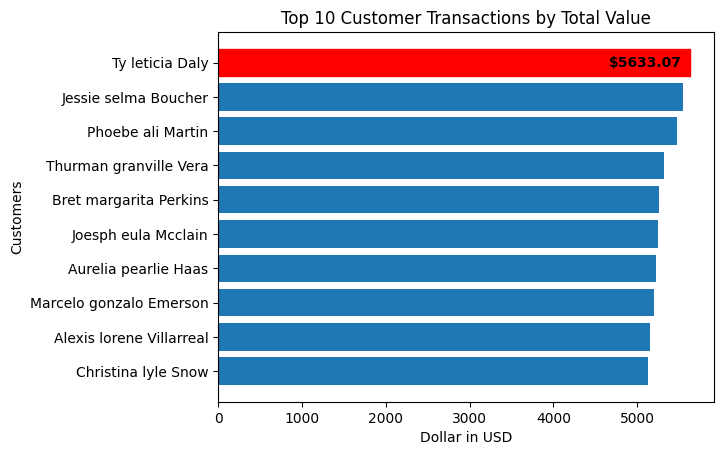

In [ ]:
my_colors = ['brown','pink', 'red', 'green', 'blue', 'cyan','orange','purple']
df_top_10_cc2 = df_top_10_cc.set_index("full_name")
#df_top_10_cc2.plot(kind="barh", legend=False, color='green')

p = plt.barh(df_top_10_cc['full_name'], df_top_10_cc['Total'])
p[0].set_color('r')
plt.text(df_top_10_cc['Total'][0]-100, 0, "$"+str(df_top_10_cc['Total'][0]), fontweight='bold', ha='right', va='center')
plt.ylim(plt.ylim()[::-1])
plt.title("Top 10 Customer Transactions by Total Value")
plt.ylabel("Customers")
plt.xlabel("Dollar in USD")
;